In [1]:
import os
import gzip
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Data

In [2]:
batch_size = 10
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/archive/train',
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9996 files belonging to 10 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/archive/val',
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 10 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 256, 256, 3)
(10,)


## Visualize input data

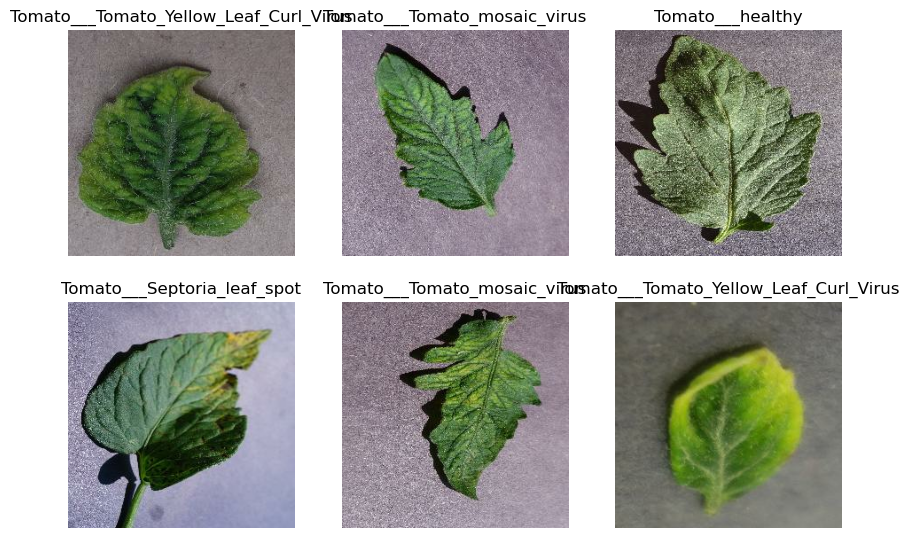

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


 ### Create Test Dataset from Validation Dataset

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))


Number of validation batches: 80
Number of test batches: 20


## Some improvements

Improve data performance by using a buffered prefetching
to load the images. buffer_size should be >= the number of batches
that are consumed by a single training step.
See https://www.tensorflow.org/guide/data_performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

###TODO 
using feature extraction doesn't allow 
to dynamically modify the input data during training
which is required for data augmentation 

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip('horizontal',
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2)
  ]
)

## Build the model

In [12]:
# Get input preprocessing/rescaling for the imported base model
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

Load base model

In [13]:
# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                            include_top=False,
                                            weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


Freeze the base model

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 64, 64, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 16, 16, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 16, 16, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 8, 8, 1280)


In [17]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [18]:
num_classes = len(class_names)
prediction_layer = Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax') 
])
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 10)


Create a new model on top of the frozen base model

In [19]:
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs) #TODO does nothing because we are running in inference mode?
x = preprocess_input(x)
# Make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning later.
# training=False is needed because model contains BatchNormalization layers
x = base_model(x, training=False) 
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
# A Dense classifier
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
len(model.trainable_variables)

4

## Train the model

In [23]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

C:\Users\mailm\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


80/80 [==============================] - 8s 82ms/step - loss: 2.5894 - accuracy: 0.1164


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.59
initial accuracy: 0.12


In [25]:
history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/20
1000/1000 [==============================] - 99s 96ms/step - loss: 1.7433 - accuracy: 0.3957 - val_loss: 1.0471 - val_accuracy: 0.7034
Epoch 2/20
1000/1000 [==============================] - 91s 91ms/step - loss: 1.1249 - accuracy: 0.6185 - val_loss: 0.8269 - val_accuracy: 0.7447
Epoch 3/20
1000/1000 [==============================] - 90s 90ms/step - loss: 0.9174 - accuracy: 0.6901 - val_loss: 0.7125 - val_accuracy: 0.7872
Epoch 4/20
1000/1000 [==============================] - 91s 91ms/step - loss: 0.8170 - accuracy: 0.7226 - val_loss: 0.6446 - val_accuracy: 0.7910
Epoch 5/20
1000/1000 [==============================] - 89s 89ms/step - loss: 0.7496 - accuracy: 0.7422 - val_loss: 0.6437 - val_accuracy: 0.7910
Epoch 6/20
1000/1000 [==============================] - 91s 91ms/step - loss: 0.6889 - accuracy: 0.7671 - val_loss: 0.5867 - val_accuracy: 0.8098
Epoch 7/20
1000/1000 [==============================] - 90s 90ms/step - loss: 0.6494 - accuracy: 0.7766 - val_loss: 0.5646 -

### Learning curves

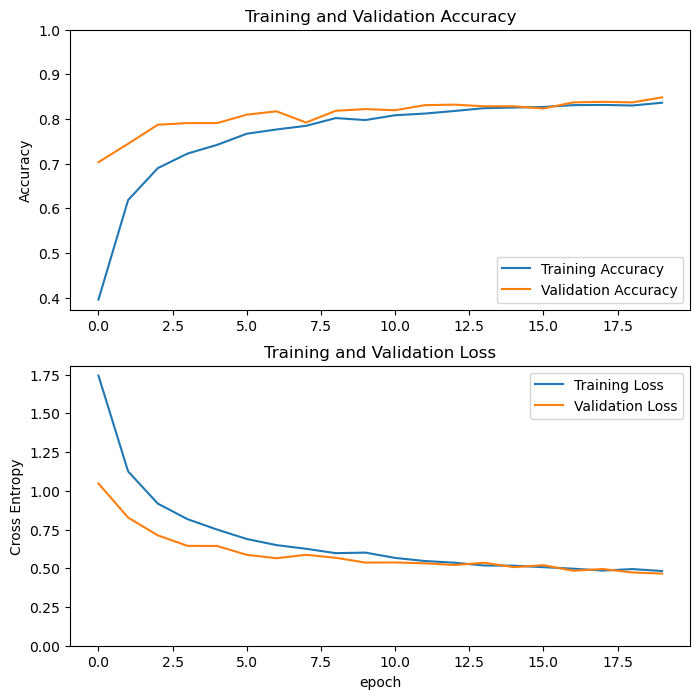

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


First predictions on not-finetuned model

In [27]:
loss_, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 1s 72ms/step - loss: 0.4584 - accuracy: 0.8400
Test accuracy : 0.8399999737739563


1/1 [==============================] - 1s 636ms/step
Predictions:
 [[0.08535623 0.23178199 0.08535068 0.08534869 0.08541464 0.08534861
  0.08535345 0.08534858 0.08534858 0.08534858]
 [0.08829462 0.1259553  0.1676031  0.08839107 0.08835218 0.08827063
  0.08832532 0.08826932 0.08826925 0.08826926]
 [0.08803586 0.08900187 0.08828848 0.08837289 0.08858184 0.08901417
  0.17967828 0.08802544 0.08804863 0.11295259]
 [0.10481695 0.10262593 0.08979009 0.09049638 0.13838723 0.09270293
  0.10962756 0.08981929 0.09200539 0.0897282 ]
 [0.08817079 0.08821341 0.08817437 0.08829019 0.08820821 0.08897703
  0.08822215 0.17282571 0.12067573 0.0882423 ]
 [0.08534814 0.08539466 0.08536803 0.23179461 0.08535338 0.08534782
  0.0853478  0.08534972 0.08534802 0.08534778]
 [0.08626989 0.21754293 0.08817895 0.08682138 0.08872192 0.08624277
  0.08755574 0.08621842 0.08621852 0.08622944]
 [0.08585552 0.08585974 0.0858226  0.08685651 0.08586881 0.08634894
  0.08600234 0.08712349 0.22417335 0.08608879]
 [0.08533902 

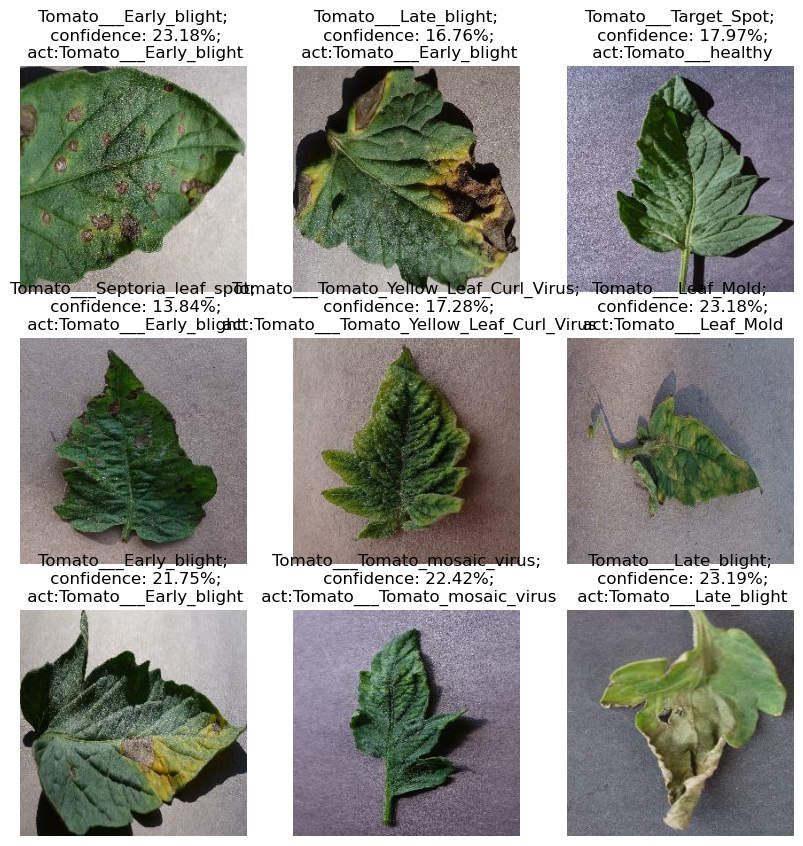

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = model.predict(image_batch)
predictions = tf.nn.softmax(predictions)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("{};\n confidence: {:.2f}%;\n act:{}".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]), class_names[label_batch[i]]))
  plt.axis("off")

### Backup model

In [29]:
# Save the weights
model.save_weights('./tomatoTFMobileNetv2_copy/checkpoints/my_checkpoint')

In [30]:
# Save the entire model as a SavedModel.
!mkdir -p tomatoTFMobileNetv2_saved_model
model.save('tomatoTFMobileNetv2_saved_model_copy/my_model')

INFO:tensorflow:Assets written to: tomatoTFMobileNetv2_saved_model_copy/my_model\assets


INFO:tensorflow:Assets written to: tomatoTFMobileNetv2_saved_model_copy/my_model\assets


In [31]:
img = tf.keras.utils.load_img(
    #'/Users/mailm/desktop/gesund.png',
    './data/archive/bacterial_spot.jpg',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to Tomato___Bacterial_spot with a 17.12 percent confidence.


In [32]:
img = tf.keras.utils.load_img(
    #'/Users/mailm/desktop/gesund.png',
    './data/archive/healthy.jpg',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Tomato___healthy with a 23.01 percent confidence.


In [33]:
img = tf.keras.utils.load_img(
    #'/Users/mailm/desktop/gesund.png',
    './data/archive/late_blight.jpg',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Tomato___Late_blight with a 22.87 percent confidence.


In [34]:
img = tf.keras.utils.load_img(
    #'/Users/mailm/desktop/gesund.png',
    './data/archive/mold.jpg',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Tomato___Leaf_Mold with a 23.07 percent confidence.


In [35]:
img = tf.keras.utils.load_img(
    #'/Users/mailm/desktop/gesund.png',
    './data/archive/yellow.jpg',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Tomato___Tomato_Yellow_Leaf_Curl_Virus with a 23.20 percent confidence.


In [36]:
restored_model = keras.models.load_model('tomatoTFMobileNetv2_saved_model_copy/my_model')
restored_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

## Try Fine Tuning

Un-freeze the top layers of the model

In [37]:
base_model.trainable = True

In [38]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Compile the model

In [40]:
# It's important to use a lower learning rate at this stage
# as the model to be trained is much larger.
# Otherwise the model could overfit very quickly
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [42]:
len(model.trainable_variables)

58

In [43]:
fine_tune_epochs = 17
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds)

Epoch 20/37


C:\Users\mailm\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1000/1000 [==============================] - 134s 129ms/step - loss: 0.4490 - accuracy: 0.8480 - val_loss: 0.3328 - val_accuracy: 0.8849
Epoch 21/37
1000/1000 [==============================] - 131s 131ms/step - loss: 0.3564 - accuracy: 0.8825 - val_loss: 0.4724 - val_accuracy: 0.8348
Epoch 22/37
1000/1000 [==============================] - 130s 130ms/step - loss: 0.3158 - accuracy: 0.8943 - val_loss: 0.2987 - val_accuracy: 0.9024
Epoch 23/37
1000/1000 [==============================] - 126s 126ms/step - loss: 0.2874 - accuracy: 0.9029 - val_loss: 0.2846 - val_accuracy: 0.9049
Epoch 24/37
1000/1000 [==============================] - 127s 127ms/step - loss: 0.2573 - accuracy: 0.9147 - val_loss: 0.2838 - val_accuracy: 0.9049
Epoch 25/37
1000/1000 [==============================] - 125s 125ms/step - loss: 0.2230 - accuracy: 0.9247 - val_loss: 0.3370 - val_accuracy: 0.8874
Epoch 26/37
1000/1000 [==============================] - 125s 125ms/step - loss: 0.2144 - accuracy: 0.9275 - val_loss:

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


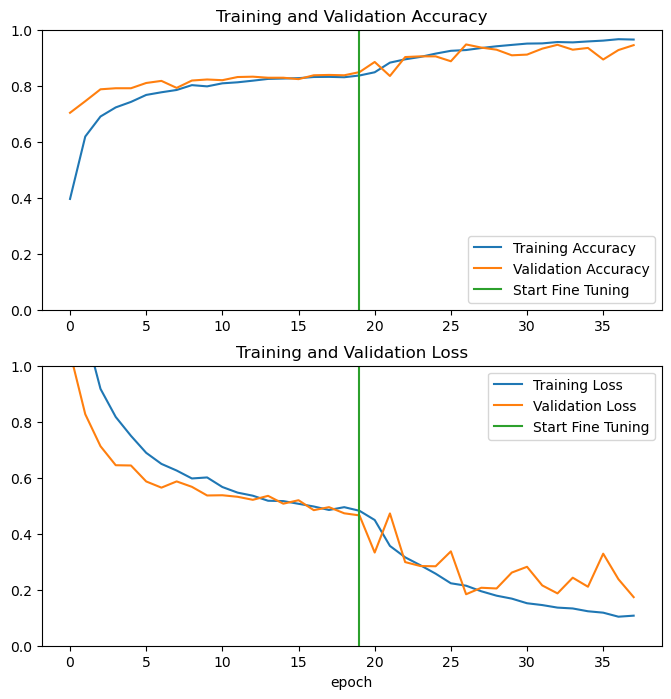

In [45]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig('MSE.svg', format='svg')


## Predictions

In [46]:
loss_, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

20/20 [==============================] - 1s 71ms/step - loss: 0.1502 - accuracy: 0.9600
Test accuracy : 0.9599999785423279


1/1 [==============================] - 1s 560ms/step
Predictions:
 [[2.43033131e-08 5.60283297e-07 1.42597436e-11 1.92916672e-11
  9.99998748e-01 3.16200954e-11 6.15037493e-07 9.70678793e-16
  6.93225199e-11 6.87380708e-11]
 [4.89572216e-10 2.66754205e-06 1.85260840e-04 9.99103367e-01
  6.95437120e-06 6.83550490e-04 2.50697923e-07 5.34176046e-08
  1.78827559e-05 1.05013109e-08]
 [4.45734422e-11 1.09608793e-08 2.24044641e-08 1.10647511e-06
  8.20553581e-08 9.99985158e-01 1.27991971e-05 2.21067396e-07
  2.99052694e-08 6.21574884e-07]
 [8.80391404e-09 1.93503347e-05 7.34732312e-04 2.08062902e-02
  9.29228463e-06 6.71836373e-04 1.64305462e-07 2.15536886e-04
  9.77542818e-01 2.89017397e-08]
 [1.44510111e-07 1.38450764e-06 1.59949577e-05 9.96076345e-01
  3.78002122e-04 3.41317221e-03 8.17702166e-05 1.92387279e-08
  3.07021364e-05 2.43560794e-06]
 [8.26739441e-11 8.47747046e-08 7.83067111e-10 1.75636590e-08
  4.86359625e-07 1.92786865e-06 9.61284474e-09 9.14741261e-09
  9.99997437e-01 1.95661

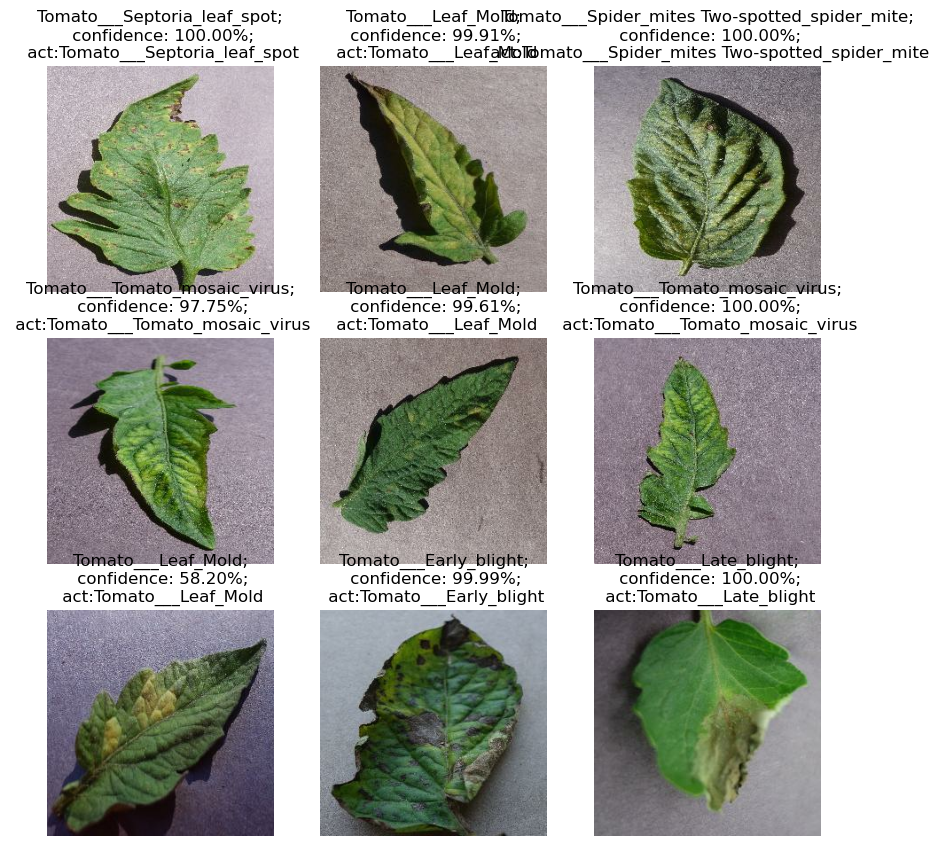

In [47]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
#predictions = model.predict_on_batch(image_batch).flatten()
predictions = model.predict(image_batch)
#predictions = tf.nn.softmax(predictions)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("{};\n confidence: {:.2f}%;\n act:{}".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]), class_names[label_batch[i]]))
  plt.axis("off")


### Backup fine tuned model

In [42]:
img = tf.keras.utils.load_img(
    './data/archive/val/Tomato___healthy/0c4b06d5-4053-44fc-99b6-504934fdd3a9___GH_HL Leaf 199.1.JPG',
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 41ms/step
This image most likely belongs to Tomato___healthy with a 23.20 percent confidence.


In [48]:
# Save the weights
model.save_weights('./tomatoTFMobileNetv2_copy/checkpoints/my_checkpoint')

In [49]:
# Save the entire model as a SavedModel.
!mkdir -p tomatoTFMobileNetv2_saved_model
model.save('tomatoTFMobileNetv2_saved_model_copy/my_model_fine_tuned')

Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.
Ein Unterverzeichnis oder eine Datei mit dem Namen "tomatoTFMobileNetv2_saved_model" existiert bereits.
Folgender Fehler trat auf: tomatoTFMobileNetv2_saved_model.


INFO:tensorflow:Assets written to: tomatoTFMobileNetv2_saved_model_copy/my_model_fine_tuned\assets


INFO:tensorflow:Assets written to: tomatoTFMobileNetv2_saved_model_copy/my_model_fine_tuned\assets


1/1 [==============================] - 0s 18ms/step


(-0.5, 255.5, 255.5, -0.5)

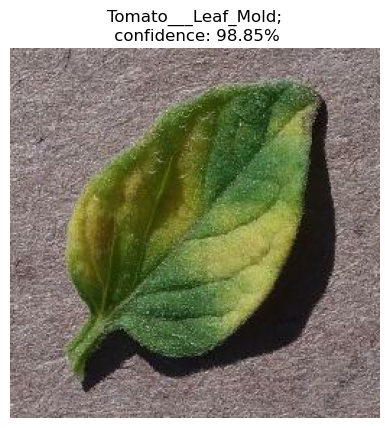

In [131]:
# Einlesen
image_file = tf.io.read_file("./data/archive/mold.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = 100 * np.max(predictions[0])

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, confidence))
plt.axis("off")

1/1 [==============================] - 0s 20ms/step


(-0.5, 255.5, 255.5, -0.5)

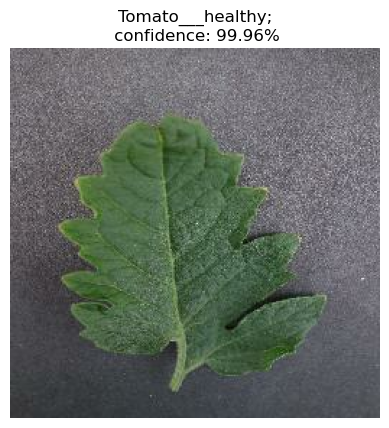

In [132]:
# Einlesen
image_file = tf.io.read_file("./data/archive/healthy.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = 100 * np.max(predictions[0])

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, confidence))
plt.axis("off")

1/1 [==============================] - 0s 25ms/step


(-0.5, 255.5, 255.5, -0.5)

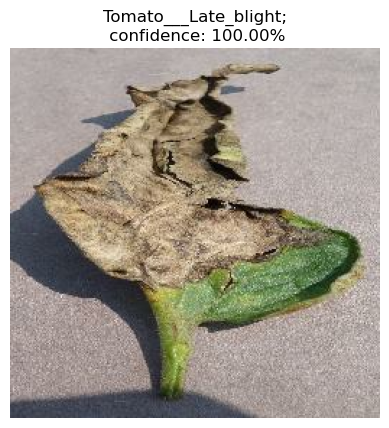

In [133]:
# Einlesen
image_file = tf.io.read_file("./data/archive/late_blight.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = 100 * np.max(predictions[0])

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, confidence))
plt.axis("off")

1/1 [==============================] - 0s 24ms/step
Tomato___Bacterial_spot: 0.63
Tomato___Early_blight: 0.00
Tomato___Late_blight: 0.00
Tomato___Leaf_Mold: 0.00
Tomato___Septoria_leaf_spot: 0.37
Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Tomato___Target_Spot: 0.00
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Tomato___Tomato_mosaic_virus: 0.00
Tomato___healthy: 0.00


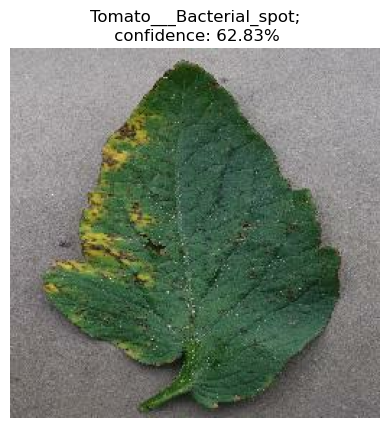

In [134]:
# Einlesen
image_file = tf.io.read_file("./data/archive/bacterial_spot.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = predictions[0]

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, 100 * confidence[np.argmax(confidence)]))
plt.axis("off")

# Confidence für alle Klassen anzeigen
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {confidence[i]:.2f}")

1/1 [==============================] - 0s 24ms/step


(-0.5, 255.5, 255.5, -0.5)

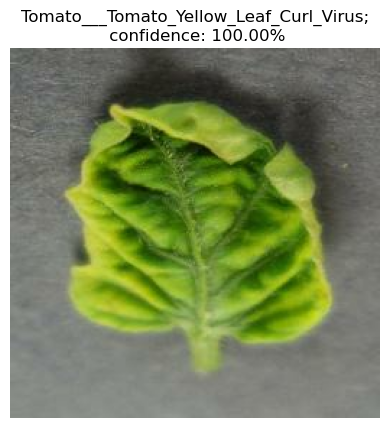

In [135]:
# Einlesen
image_file = tf.io.read_file("./data/archive/yellow.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = 100 * np.max(predictions[0])

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, confidence))
plt.axis("off")

1/1 [==============================] - 0s 24ms/step
Tomato___Bacterial_spot: 0.00
Tomato___Early_blight: 0.00
Tomato___Late_blight: 0.00
Tomato___Leaf_Mold: 0.00
Tomato___Septoria_leaf_spot: 0.02
Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Tomato___Target_Spot: 0.42
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Tomato___Tomato_mosaic_virus: 0.00
Tomato___healthy: 0.56


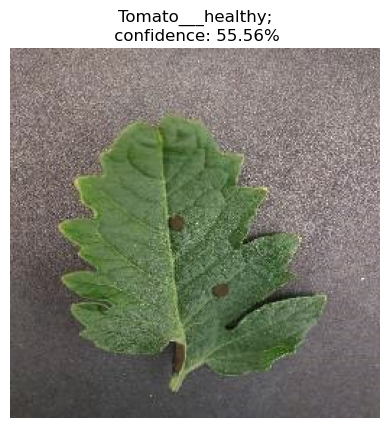

In [136]:
# Einlesen
image_file = tf.io.read_file("./data/archive/test.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = predictions[0]

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, 100 * confidence[np.argmax(confidence)]))
plt.axis("off")

# Confidence für alle Klassen anzeigen
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {confidence[i]:.2f}")

1/1 [==============================] - 0s 24ms/step
Tomato___Bacterial_spot: 0.00
Tomato___Early_blight: 0.00
Tomato___Late_blight: 0.00
Tomato___Leaf_Mold: 0.00
Tomato___Septoria_leaf_spot: 0.89
Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Tomato___Target_Spot: 0.00
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Tomato___Tomato_mosaic_virus: 0.00
Tomato___healthy: 0.11


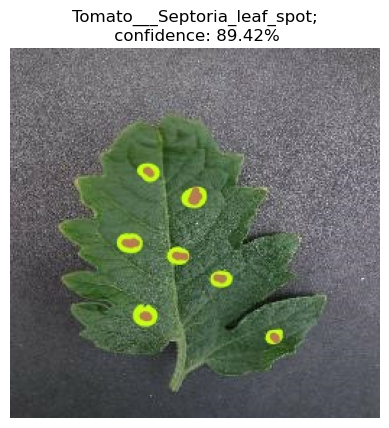

In [137]:
# Einlesen
image_file = tf.io.read_file("./data/archive/test2.jpg")

# Decodieren
image = tf.image.decode_image(image_file)

# Dimension hinzufügen
image = tf.expand_dims(image, 0)

# Vorhersagen
predictions = model.predict(image)

# Klasse und Confidence
predicted_class = class_names[np.argmax(predictions[0])]
confidence = predictions[0]

# Anzeige generieren
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("{};\n confidence: {:.2f}%".format(predicted_class, 100 * confidence[np.argmax(confidence)]))
plt.axis("off")

# Confidence für alle Klassen anzeigen
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {confidence[i]:.2f}")